**ParaBERT embedding on Subject**
- Subject+Category/Subject+Category+HazardType+Origin
- LightGBM/XGBoost/RandomForest/LogisticRegression
- Best result - LightGBM with four features

In [62]:
import pandas as pd
import numpy as np
import re

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [63]:
# ============================================================
# 1. Clean Text Functions
# ============================================================

def clean_text(text):
    if text is None:
        return ""
    text = str(text)

    # Replace multiple slashes with space
    text = re.sub(r'/+', ' ', text)

    # Add space between number and letters: 25g → 25 g
    text = re.sub(r'(\d)([A-Za-z])', r'\1 \2', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [64]:

# ============================================================
# 2. Load Data
# ============================================================

df = pd.read_csv("/content/df_keyword.csv")   # ← change this

# Clean subject + category
df["subject_clean"] = df["subject"].apply(clean_text)

In [65]:
# ----------------------------
# 3. Recode risk_decision into 3 classes
# ----------------------------
def recode_risk(risk):
    if risk in ['no risk', 'not serious']:
        return 0   # Low risk
    elif risk in ['potential risk', 'undecided', 'potentially serious']:
        return 1   # Medium / potential risk
    elif risk == 'serious':
        return 2   # High risk
    else:
        return -1  # Safety net for unexpected values

# Apply to both train and test
df['risk_decision_3class'] = df['risk_decision'].apply(recode_risk)


# Optional: check distribution
print(df['risk_decision_3class'].value_counts())


risk_decision_3class
2    14756
1     8090
0     4551
Name: count, dtype: int64


In [66]:
# ============================================================
# 4. ParaBERT Embeddings (only subject + category)
# ============================================================

model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")

print("Encoding SUBJECT…")
subject_embeddings = model.encode(df["subject_clean"].tolist(), show_progress_bar=True)


# Combine embeddings
X = np.hstack([subject_embeddings])

# Encode target
y = df["risk_decision_3class"]

Encoding SUBJECT…


Batches:   0%|          | 0/857 [00:00<?, ?it/s]

In [67]:
# ============================================================
# 5. Train-test split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [69]:
# ---------------------------------------------------------
# 6. DEFINE BASELINE MODELS
# ---------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(tree_method="hist", eval_metric="mlogloss", use_label_encoder=False, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42)
}


# ---------------------------------------------------------
# 7. TRAIN, EVALUATE, COLLECT RESULTS
# ---------------------------------------------------------
results = {}

for name, clf in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data only for Logistic Regression
    if name == "Logistic Regression":
        clf.fit(X_train_scaled, y_train)
        preds = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")
    results[name] = {"accuracy": acc, "f1_macro": f1}

    print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, preds))




Training Logistic Regression...
Accuracy: 0.6746 | F1-macro: 0.6115
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.45      0.51       910
           1       0.58      0.51      0.54      1618
           2       0.73      0.83      0.78      2952

    accuracy                           0.67      5480
   macro avg       0.64      0.60      0.61      5480
weighted avg       0.66      0.67      0.67      5480


Training Random Forest...
Accuracy: 0.7064 | F1-macro: 0.6327
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.37      0.51       910
           1       0.65      0.55      0.59      1618
           2       0.72      0.90      0.80      2952

    accuracy                           0.71      5480
   macro avg       0.72      0.61      0.63      5480
weighted avg       0.71      0.71      0.69      5480


Training XGBoost...
Accuracy: 0.7190 | F1-macro: 0.6684
Cla

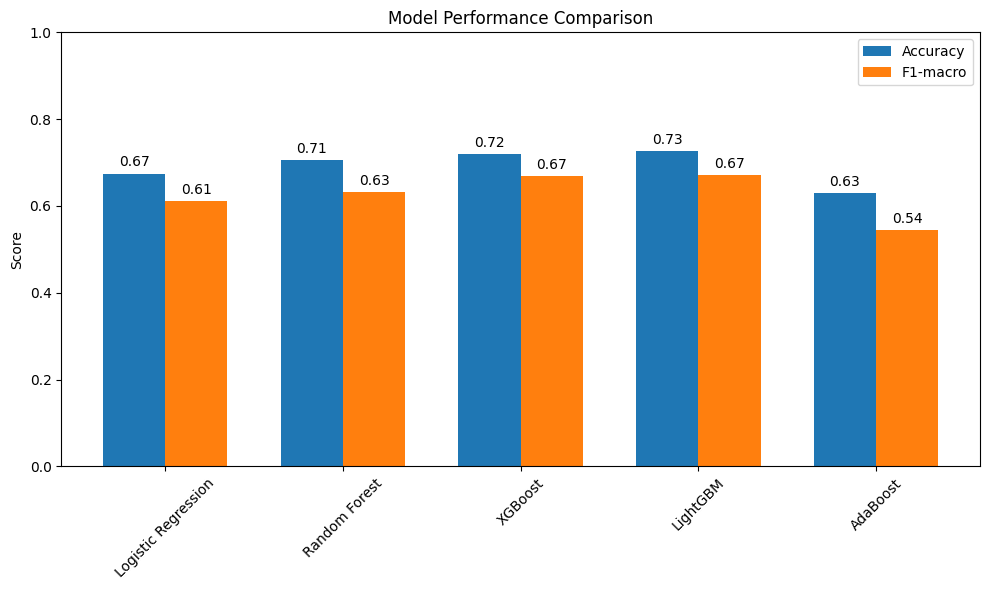

In [70]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 7. PLOT COMPARISON CHART
# ---------------------------------------------------------
model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]
f1_scores = [results[m]["f1_macro"] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-macro')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0, 1)
ax.legend()

# Add data labels on top of bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [20]:

# ============================================================
# 2. Load Data
# ============================================================

df = pd.read_csv("/content/df_keyword.csv")   # ← change this

# Clean subject + category
df["subject_clean"] = df["subject"].apply(clean_text)
df["category_clean"] = df["category"].apply(clean_text)

In [21]:
# ----------------------------
# 3. Recode risk_decision into 3 classes
# ----------------------------
def recode_risk(risk):
    if risk in ['no risk', 'not serious']:
        return 0   # Low risk
    elif risk in ['potential risk', 'undecided', 'potentially serious']:
        return 1   # Medium / potential risk
    elif risk == 'serious':
        return 2   # High risk
    else:
        return -1  # Safety net for unexpected values

# Apply to both train and test
df['risk_decision_3class'] = df['risk_decision'].apply(recode_risk)


# Optional: check distribution
print(df['risk_decision_3class'].value_counts())



risk_decision_3class
2    14756
1     8090
0     4551
Name: count, dtype: int64


In [22]:
# ============================================================
# 4. ParaBERT Embeddings (only subject + category)
# ============================================================

model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")

print("Encoding SUBJECT…")
subject_embeddings = model.encode(df["subject_clean"].tolist(), show_progress_bar=True)

print("Encoding CATEGORY…")
category_embeddings = model.encode(df["category_clean"].tolist(), show_progress_bar=True)

# Combine both embeddings
X = np.hstack([subject_embeddings, category_embeddings])

# Encode target
y = df["risk_decision_3class"]

Encoding SUBJECT…


Batches:   0%|          | 0/857 [00:00<?, ?it/s]

Encoding CATEGORY…


Batches:   0%|          | 0/857 [00:00<?, ?it/s]

In [23]:
# ============================================================
# 5. Train-test split
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:

# ---------------------------------------------------------
# 6. DEFINE BASELINE MODELS
# ---------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(tree_method="hist", eval_metric="mlogloss", use_label_encoder=False, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, random_state=42),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42)
}


# ---------------------------------------------------------
# 7. TRAIN, EVALUATE, COLLECT RESULTS
# ---------------------------------------------------------
results = {}

for name, clf in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data only for Logistic Regression
    if name == "Logistic Regression":
        clf.fit(X_train_scaled, y_train)
        preds = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")
    results[name] = {"accuracy": acc, "f1_macro": f1}

    print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, preds))





Training Logistic Regression...
Accuracy: 0.6850 | F1-macro: 0.6263
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.49      0.54       910
           1       0.58      0.51      0.54      1618
           2       0.75      0.84      0.79      2952

    accuracy                           0.69      5480
   macro avg       0.65      0.61      0.63      5480
weighted avg       0.67      0.69      0.68      5480


Training Random Forest...
Accuracy: 0.7206 | F1-macro: 0.6637
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.48      0.59       910
           1       0.66      0.53      0.59      1618
           2       0.73      0.90      0.81      2952

    accuracy                           0.72      5480
   macro avg       0.72      0.64      0.66      5480
weighted avg       0.72      0.72      0.71      5480


Training XGBoost...
Accuracy: 0.7224 | F1-macro: 0.6741
Cla

NameError: name 'plt' is not defined

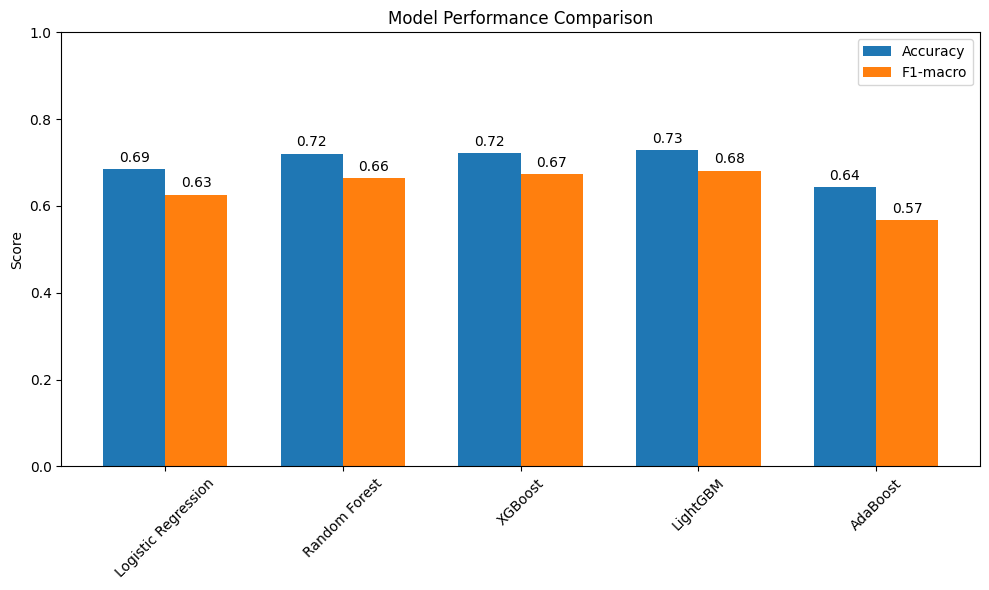

In [25]:
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# 7. PLOT COMPARISON CHART
# ---------------------------------------------------------
model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]
f1_scores = [results[m]["f1_macro"] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-macro')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0, 1)
ax.legend()

# Add data labels on top of bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [27]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")

In [29]:
# ============================================================
# 1. Clean Text Functions
# ============================================================

def clean_text(text):
    if text is None:
        return ""
    text = str(text)

    # Replace multiple slashes with space
    text = re.sub(r'/+', ' ', text)

    # Add space between number and letters: 25g → 25 g
    text = re.sub(r'(\d)([A-Za-z])', r'\1 \2', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [30]:

# ============================================================
# 2. Load Data
# ============================================================

df = pd.read_csv("/content/df_keyword.csv")   # ← change this

# Clean subject + category
df["subject_clean"] = df["subject"].apply(clean_text)
df["category_clean"] = df["category"].apply(clean_text)

In [31]:
# ----------------------------
# Recode risk_decision into 3 classes
# ----------------------------
def recode_risk(risk):
    if risk in ['no risk', 'not serious']:
        return 0   # Low risk
    elif risk in ['potential risk', 'undecided', 'potentially serious']:
        return 1   # Medium / potential risk
    elif risk == 'serious':
        return 2   # High risk
    else:
        return -1  # Safety net for unexpected values

# Apply to both train and test
df['risk_decision_3class'] = df['risk_decision'].apply(recode_risk)


# Optional: check distribution
print(df['risk_decision_3class'].value_counts())

risk_decision_3class
2    14756
1     8090
0     4551
Name: count, dtype: int64


In [32]:
# ============================================================
# 4. ParaBERT Embeddings (only subject + category)
# ============================================================

model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2")

print("Encoding SUBJECT…")
subject_embeddings = model.encode(df["subject_clean"].tolist(), show_progress_bar=True)

print("Encoding CATEGORY…")
category_embeddings = model.encode(df["category_clean"].tolist(), show_progress_bar=True)

# Combine both embeddings
X = np.hstack([subject_embeddings, category_embeddings])

# Encode target
y = df["risk_decision_3class"]

Encoding SUBJECT…


Batches:   0%|          | 0/857 [00:00<?, ?it/s]

Encoding CATEGORY…


Batches:   0%|          | 0/857 [00:00<?, ?it/s]

In [34]:
#Hazard type one-hot
hazard_ohe = pd.get_dummies(df["Hazard_Type"], prefix="hazard")

In [38]:
#Origin multi-hot
# Replace NaN with empty string
df["origin"] = df["origin"].fillna("")

# Split by delimiter if multiple origins
df["origin_list"] = df["origin"].str.split(r"[,/]+")
all_origins = sorted(set([o.strip() for sublist in df["origin_list"] for o in sublist if o.strip()]))

for o in all_origins:
    df[f"origin_{o}"] = df["origin_list"].apply(lambda x: 1 if o in [i.strip() for i in x] else 0)

origin_features = df[[f"origin_{o}" for o in all_origins]]

In [42]:
X = np.hstack([subject_embeddings, category_embeddings, hazard_ohe.values, origin_features.values])
y = df["risk_decision_3class"]

X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# ---------------------------------------------------------
# 5. DEFINE BASELINE MODELS
# ---------------------------------------------------------
models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=42),
    "XGBoost": XGBClassifier(tree_method="hist", eval_metric="mlogloss", use_label_encoder=False, random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, random_state=42),
}


# ---------------------------------------------------------
# 6. TRAIN, EVALUATE, COLLECT RESULTS
# ---------------------------------------------------------
results = {}

for name, clf in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data only for Logistic Regression
    if name == "Logistic Regression":
        clf.fit(X_train_scaled, y_train)
        preds = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average="macro")
    results[name] = {"accuracy": acc, "f1_macro": f1}

    print(f"Accuracy: {acc:.4f} | F1-macro: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_test, preds))


Training Logistic Regression...
Accuracy: 0.6889 | F1-macro: 0.6332
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.52      0.56       910
           1       0.58      0.52      0.55      1618
           2       0.75      0.84      0.79      2952

    accuracy                           0.69      5480
   macro avg       0.65      0.62      0.63      5480
weighted avg       0.68      0.69      0.68      5480


Training Random Forest...
Accuracy: 0.7318 | F1-macro: 0.6769
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.50      0.60       910
           1       0.66      0.56      0.61      1618
           2       0.75      0.90      0.82      2952

    accuracy                           0.73      5480
   macro avg       0.73      0.65      0.68      5480
weighted avg       0.73      0.73      0.72      5480


Training XGBoost...
Accuracy: 0.7285 | F1-macro: 0.6803
Cla

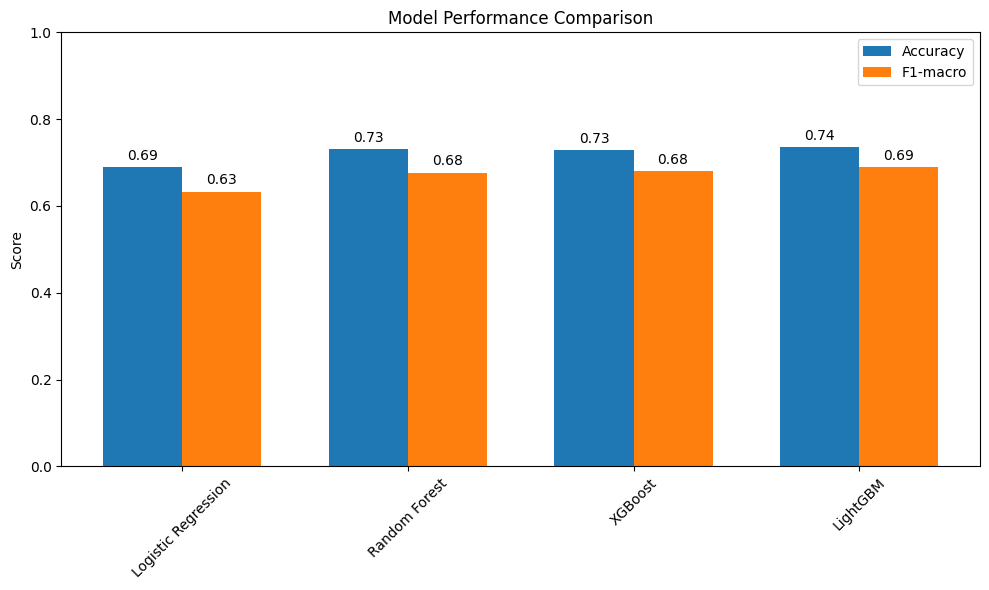

In [46]:
# ---------------------------------------------------------
# 7. PLOT COMPARISON CHART
# ---------------------------------------------------------
model_names = list(results.keys())
accuracies = [results[m]["accuracy"] for m in model_names]
f1_scores = [results[m]["f1_macro"] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, accuracies, width, label='Accuracy')
rects2 = ax.bar(x + width/2, f1_scores, width, label='F1-macro')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.set_ylim(0, 1)
ax.legend()

# Add data labels on top of bars
for rects in [rects1, rects2]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [47]:
# Example for LightGBM
importances = models["LightGBM"].feature_importances_

# Optionally, split by feature type
num_subject_features = subject_embeddings.shape[1]
num_category_features = category_embeddings.shape[1]
num_hazard_features = hazard_ohe.shape[1]
num_origin_features = origin_features.shape[1]

# Aggregate by feature type
importance_subject = importances[:num_subject_features].mean()
importance_category = importances[num_subject_features:num_subject_features+num_category_features].mean()
importance_hazard = importances[num_subject_features+num_category_features:
                                num_subject_features+num_category_features+num_hazard_features].mean()
importance_origin = importances[-num_origin_features:].mean()

print("Feature importance by type (average over features):")
print(f"Subject embeddings: {importance_subject:.4f}")
print(f"Category embeddings: {importance_category:.4f}")
print(f"Hazard type: {importance_hazard:.4f}")
print(f"Origin: {importance_origin:.4f}")

Feature importance by type (average over features):
Subject embeddings: 64.8229
Category embeddings: 4.4193
Hazard type: 25.3333
Origin: 1.1024


In [56]:
# Get feature importance dictionary
importances_dict = models["XGBoost"].get_booster().get_score(importance_type='gain')

# Convert to a full array
num_features = X.shape[1]
importances = np.zeros(num_features)
for k, v in importances_dict.items():
    idx = int(k[1:])  # 'f0', 'f1', ...
    importances[idx] = v

# Number of features per group
num_subject_features = subject_embeddings.shape[1]
num_category_features = category_embeddings.shape[1]
num_hazard_features = hazard_ohe.shape[1]
num_origin_features = origin_features.shape[1]

# Aggregate average importance per group
importance_subject = importances[:num_subject_features].mean()
importance_category = importances[num_subject_features:num_subject_features+num_category_features].mean()
importance_hazard = importances[num_subject_features+num_category_features:
                                num_subject_features+num_category_features+num_hazard_features].mean()
importance_origin = importances[-num_origin_features:].mean()

print("Feature importance by type (average over features):")
print(f"Subject embeddings: {importance_subject:.4f}")
print(f"Category embeddings: {importance_category:.4f}")
print(f"Hazard type: {importance_hazard:.4f}")
print(f"Origin: {importance_origin:.4f}")

Feature importance by type (average over features):
Subject embeddings: 3.6904
Category embeddings: 6.8589
Hazard type: 35.9201
Origin: 1.0893


In [60]:
# Feature importances for Random Forest
importances = models["XGBoost"].feature_importances_

# Number of features per group
num_subject_features = subject_embeddings.shape[1]
num_category_features = category_embeddings.shape[1]
num_hazard_features = hazard_ohe.shape[1]
num_origin_features = origin_features.shape[1]

# sum importance per group
importance_subject = importances[:num_subject_features].sum()
importance_category = importances[num_subject_features:num_subject_features+num_category_features].sum()
importance_hazard = importances[num_subject_features+num_category_features:
                                num_subject_features+num_category_features+num_hazard_features].sum()
importance_origin = importances[-num_origin_features:].sum()

print("XGBoost feature importance by type (average over features):")
print(f"Subject embeddings: {importance_subject:.4f}")
print(f"Category embeddings: {importance_category:.4f}")
print(f"Hazard type: {importance_hazard:.4f}")
print(f"Origin: {importance_origin:.4f}")

XGBoost feature importance by type (average over features):
Subject embeddings: 0.3111
Category embeddings: 0.5782
Hazard type: 0.0710
Origin: 0.0397


In [57]:
# Feature importances for Random Forest
importances = models["Random Forest"].feature_importances_

# Number of features per group
num_subject_features = subject_embeddings.shape[1]
num_category_features = category_embeddings.shape[1]
num_hazard_features = hazard_ohe.shape[1]
num_origin_features = origin_features.shape[1]

# Aggregate average importance per group
importance_subject = importances[:num_subject_features].mean()
importance_category = importances[num_subject_features:num_subject_features+num_category_features].mean()
importance_hazard = importances[num_subject_features+num_category_features:
                                num_subject_features+num_category_features+num_hazard_features].mean()
importance_origin = importances[-num_origin_features:].mean()

print("Random Forest feature importance by type (average over features):")
print(f"Subject embeddings: {importance_subject:.4f}")
print(f"Category embeddings: {importance_category:.4f}")
print(f"Hazard type: {importance_hazard:.4f}")
print(f"Origin: {importance_origin:.4f}")

Random Forest feature importance by type (average over features):
Subject embeddings: 0.0022
Category embeddings: 0.0003
Hazard type: 0.0022
Origin: 0.0000


In [58]:
# Feature importances for Random Forest
importances = models["Random Forest"].feature_importances_

# Number of features per group
num_subject_features = subject_embeddings.shape[1]
num_category_features = category_embeddings.shape[1]
num_hazard_features = hazard_ohe.shape[1]
num_origin_features = origin_features.shape[1]

# sum importance per group
importance_subject = importances[:num_subject_features].sum()
importance_category = importances[num_subject_features:num_subject_features+num_category_features].sum()
importance_hazard = importances[num_subject_features+num_category_features:
                                num_subject_features+num_category_features+num_hazard_features].sum()
importance_origin = importances[-num_origin_features:].sum()

print("Random Forest feature importance by type (average over features):")
print(f"Subject embeddings: {importance_subject:.4f}")
print(f"Category embeddings: {importance_category:.4f}")
print(f"Hazard type: {importance_hazard:.4f}")
print(f"Origin: {importance_origin:.4f}")

Random Forest feature importance by type (average over features):
Subject embeddings: 0.8452
Category embeddings: 0.1306
Hazard type: 0.0201
Origin: 0.0041


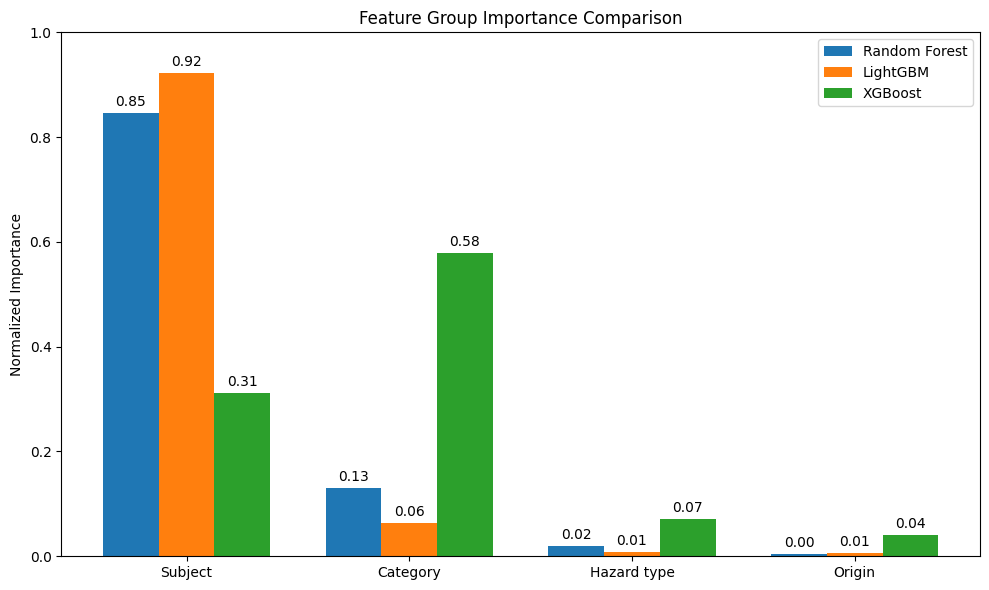

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Feature group sizes
num_subject_features = subject_embeddings.shape[1]
num_category_features = category_embeddings.shape[1]
num_hazard_features = hazard_ohe.shape[1]
num_origin_features = origin_features.shape[1]

feature_groups = ["Subject", "Category", "Hazard type", "Origin"]

# Dictionary to store group importance
group_importances = {}

# --- Random Forest ---
rf_importances = models["Random Forest"].feature_importances_
group_importances["Random Forest"] = [
    rf_importances[:num_subject_features].sum(),
    rf_importances[num_subject_features:num_subject_features+num_category_features].sum(),
    rf_importances[num_subject_features+num_category_features:
                   num_subject_features+num_category_features+num_hazard_features].sum(),
    rf_importances[-num_origin_features:].sum()
]

# --- LightGBM ---
lgb_importances = models["LightGBM"].feature_importances_
group_importances["LightGBM"] = [
    lgb_importances[:num_subject_features].sum(),
    lgb_importances[num_subject_features:num_subject_features+num_category_features].sum(),
    lgb_importances[num_subject_features+num_category_features:
                    num_subject_features+num_category_features+num_hazard_features].sum(),
    lgb_importances[-num_origin_features:].sum()
]

# --- XGBoost ---
xgb_importances_dict = models["XGBoost"].get_booster().get_score(importance_type='gain')
num_features = X.shape[1]
xgb_importances = np.zeros(num_features)
for k, v in xgb_importances_dict.items():
    idx = int(k[1:])
    xgb_importances[idx] = v
group_importances["XGBoost"] = [
    xgb_importances[:num_subject_features].sum(),
    xgb_importances[num_subject_features:num_subject_features+num_category_features].sum(),
    xgb_importances[num_subject_features+num_category_features:
                    num_subject_features+num_category_features+num_hazard_features].sum(),
    xgb_importances[-num_origin_features:].sum()
]

# --- Normalize to 0-1 for each model ---
for key in group_importances:
    total = sum(group_importances[key])
    group_importances[key] = [v/total for v in group_importances[key]]

# --- Plot ---
x = np.arange(len(feature_groups))
width = 0.25
fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width, group_importances["Random Forest"], width, label='Random Forest')
rects2 = ax.bar(x, group_importances["LightGBM"], width, label='LightGBM')
rects3 = ax.bar(x + width, group_importances["XGBoost"], width, label='XGBoost')

ax.set_ylabel('Normalized Importance')
ax.set_title('Feature Group Importance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(feature_groups)
ax.set_ylim(0, 1)
ax.legend()

for rects in [rects1, rects2, rects3]:
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0,3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()